In [1]:
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, BatchNormalization
from keras.constraints import max_norm
from PIL import Image
import skimage

Using TensorFlow backend.


In [3]:
#path = '/home/grads/n/narendra5/Desktop/Programs/LER_machine_learning/'
path = r"C:\\Users\\narendra\\Documents\\LER\\"

#model = load_model(path + 'models/' + 'EDGEnet2_round_L1_epoch_4.h5')
model = load_model(path + 'LER_machine_learning\\models\\' + 'EDGEnet2_round_L1_epoch_4.h5')
#model.summary()

In [83]:
sigma = 1.2
alpha = 0.5
Xi = 30
width = 20
space = 20
noise = 2
shift = math.floor(-25 + (width + space/2 + Xi + alpha*10 + sigma*10)%16) 

#original_file = path + 'original_images2/oim_' + "{:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '_' + str(-shift) + '.tiff'
#noisy_file = path + 'noisy_images2/nim_' + "{0:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '_' + str(-shift) + '_' + str(noise) + '.tiff'

original_file = path + 'original_images2\\oim_' + "{:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '_' + str(-shift) + '.tiff'
noisy_file = path + 'noisy_images2\\nim_' + "{0:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '_' + str(-shift) + '_' + str(noise) + '.tiff'


imnoisy = np.array(Image.open(noisy_file))
im = np.array(Image.open(original_file))

imnoisy = (imnoisy)/256
imnoisy = imnoisy.reshape(1,1024,64,1)

linepredict = model.predict(imnoisy)

imnoisy = imnoisy.reshape(1024,64)
linepredict = linepredict.reshape(1024,2)
print(linepredict.shape)

(1024, 2)


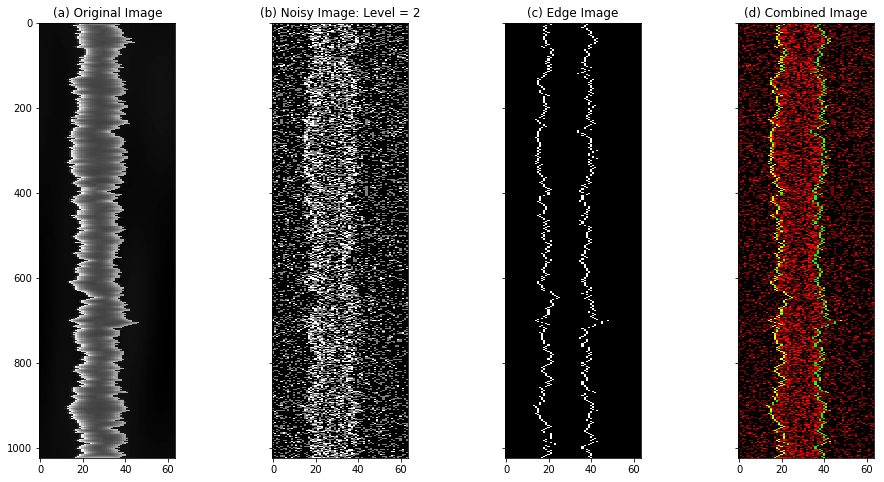

In [84]:

%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 8), sharex=True,
                       sharey=True, subplot_kw={'adjustable': 'box-forced'})

ax[0].imshow(im,cmap = 'gray',aspect= 0.2)
ax[0].set_title('(a) Original Image')

ax[1].imshow(imnoisy,cmap = 'gray',aspect= 0.2)
ax[1].set_title('(b) Noisy Image: Level = {}'.format(noise))

edgepredict = np.zeros((1024,64))
i =[]
for i in range(1024):
    edgepredict[i, (linepredict*64).round().astype(int)[i,0]] = 1
    edgepredict[i, (linepredict*64).round().astype(int)[i,1]] = 1
    
ax[2].imshow(edgepredict, cmap = 'gray',aspect= 0.2)
ax[2].set_title('(c) Edge Image')

combine = np.zeros((1024,64,3))
combine[:,:,0] = imnoisy
combine[:,:,1] = edgepredict

ax[3].imshow(combine, cmap = 'gray', aspect= 0.2)
ax[3].set_title('(d) Combined Image')

plt.show()


Original leftline sigma = 1.1000844359503015, rightline sigma = 1.0679967847268501
Predicted leftline sigma = 1.0600972175598145, rightline sigma = 0.9675155282020569
539.0
670.0
Mean absolute position error = 0.59033203125
Original LWR = 1.639057100503499 
Predicted LWR = 1.5392953157424927 
LWR_accuracy = 93.91346495919143
Left_LER_accuracy = 96.36507734463635
Right_LER_accuracy = 90.59161432302511


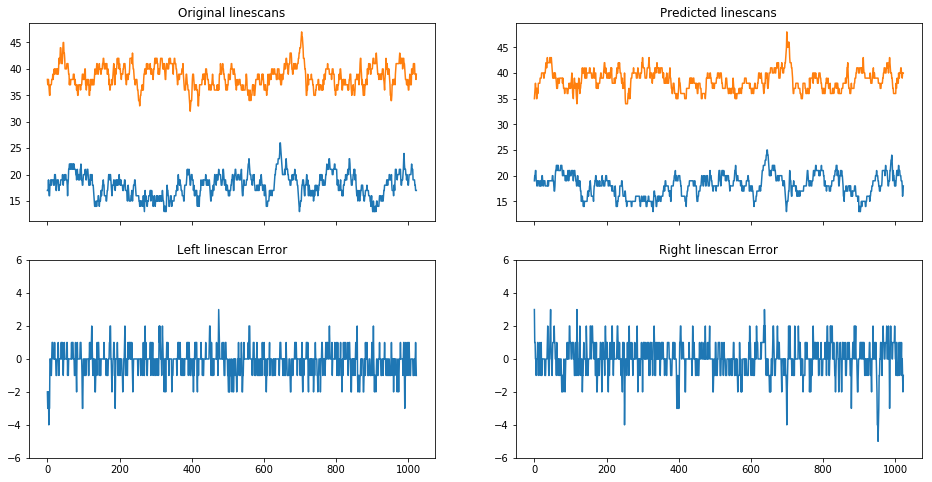

In [85]:
#linescan_file = path + 'linescans/linescan_' + "{:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '.txt'
linescan_file = path + 'linescans\\linescan_' + "{:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '.txt'

linescan = []
with open(linescan_file,'r') as f:
    for i, line in enumerate(f):
        if i < 3000:
            a, b = line.split(',')
            linescan.append(float(b))


linescan = linescan[:2048]

leftline = np.array(linescan[:1024]) 
rightline = linescan[1024:]
rightline.reverse()
rightline = np.array(rightline)

leftline = leftline + shift
rightline = rightline + shift

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 8), sharex=True,
                       sharey=False, subplot_kw={'adjustable': 'box-forced'})

Original_left_LER = leftline.round().std()/2
Original_right_LER = rightline.round().std()/2
Predicted_left_LER = (linepredict*64).round()[:,0].std()/2
Predicted_right_LER = (linepredict*64).round()[:,1].std()/2
print('Original leftline sigma = {}, rightline sigma = {}'.format(Original_left_LER, Original_right_LER))
print('Predicted leftline sigma = {}, rightline sigma = {}'.format(Predicted_left_LER, Predicted_right_LER))

left_error = np.abs(leftline.round() - (linepredict*64).round()[:,0]).sum()
right_error = np.abs(rightline.round() - (linepredict*64).round()[:,1]).sum()
print(left_error)
print(right_error)
print('Mean absolute position error = {}'.format((left_error + right_error)/2048))

Original_LWR = (rightline.round() - leftline.round()).std()/2
Predicted_LWR = ((linepredict*64).round()[:,0] - (linepredict*64).round()[:,1]).std()/2

print('Original LWR = {} '.format(Original_LWR))
print('Predicted LWR = {} '.format(Predicted_LWR))
print('LWR_accuracy = {}'.format(100 - (100*np.abs(Predicted_LWR - Original_LWR)/Original_LWR)))
print('Left_LER_accuracy = {}'.format(100 - (100*np.abs(Predicted_left_LER - Original_left_LER)/Original_left_LER)))
print('Right_LER_accuracy = {}'.format(100 - (100*np.abs(Predicted_right_LER - Original_right_LER)/Original_right_LER)))

ax[0,0].plot(leftline.round())
ax[0,0].plot(rightline.round())
ax[0,0].set_title('Original linescans')

ax[0,1].plot((linepredict*64).round())
ax[0,1].set_title('Predicted linescans')

ax[1,0].plot(leftline.round() - (linepredict*64).round()[:,0])
ax[1,0].set_title('Left linescan Error')
ax[1,0].set_ylim([-6,6])

ax[1,1].plot(rightline.round() - (linepredict*64).round()[:,1])
ax[1,1].set_title('Right linescan Error')
ax[1,1].set_ylim([-6,6])

plt.show()

Left Bias:  294.665166365
Right Bias:  417.90433409


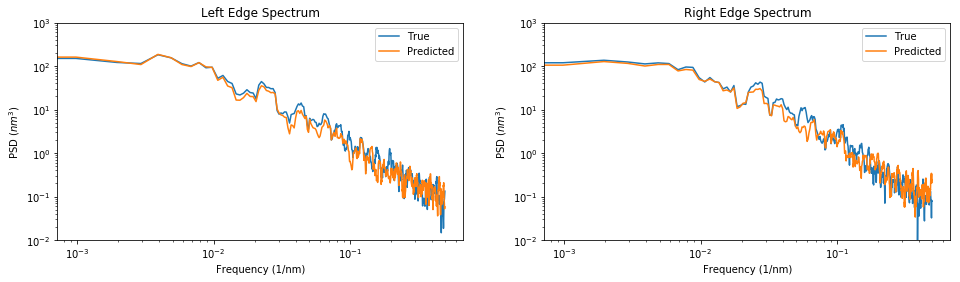

In [86]:
from spectrum import pmtm

# Spectrum analysis code by Sai
NFFT_VAL = 1024
range_psd = int(NFFT_VAL/2)

#leftmean = leftline.mean()
#rightmean = rightline.mean()
leftmean = 30 + shift                     # Change the mean to zero
rightmean = 30 + shift + width            # Change the mean to zero

leftline_spec = leftline - leftmean
rightline_spec = rightline - rightmean

#leftpred_spec = (linepredict*64).round()[:,0] - (linepredict*64).round()[:,0].mean()
#rightpred_spec = (linepredict*64).round()[:,1] - (linepredict*64).round()[:,1].mean()

leftpred_spec = (linepredict*64).round()[:,0] - leftmean
rightpred_spec = (linepredict*64).round()[:,1] - rightmean

left_multitape_spectrum = pmtm(leftline_spec, NFFT = NFFT_VAL, NW = 4, k=6, method = 'adapt', show = False)
left_Sk = abs(left_multitape_spectrum[0])**2
left_Sk = np.mean(left_Sk * np.transpose(left_multitape_spectrum[1]), axis = 0)
left_Sk = np.fft.fftshift(left_Sk)

right_multitape_spectrum = pmtm(rightline_spec, NFFT = NFFT_VAL, NW = 4, k=6, method = 'adapt', show = False)
right_Sk = abs(right_multitape_spectrum[0])**2
right_Sk = np.mean(right_Sk * np.transpose(right_multitape_spectrum[1]), axis = 0)
right_Sk = np.fft.fftshift(right_Sk)

left_multitape_spectrum_predict = pmtm(leftpred_spec, NFFT = NFFT_VAL, NW = 4, k=6, method = 'adapt', show = False)
left_Sk_predict = abs(left_multitape_spectrum_predict[0])**2
left_Sk_predict = np.mean(left_Sk_predict * np.transpose(left_multitape_spectrum_predict[1]), axis = 0)
left_Sk_predict = np.fft.fftshift(left_Sk_predict)

right_multitape_spectrum_predict = pmtm(rightpred_spec, NFFT = NFFT_VAL, NW = 4, k=6, method = 'adapt', show = False)
right_Sk_predict = abs(right_multitape_spectrum_predict[0])**2
right_Sk_predict = np.mean(right_Sk_predict * np.transpose(right_multitape_spectrum_predict[1]), axis = 0)
right_Sk_predict = np.fft.fftshift(right_Sk_predict)


left_bias = np.sum(np.abs((left_Sk_predict[512:] - left_Sk[512:])/left_Sk[512:]))
right_bias = np.sum(np.abs((right_Sk_predict[512:] - right_Sk[512:])/right_Sk[512:]))

print('Left Bias: ', left_bias)
print('Right Bias: ', right_bias)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4), sharex=True,
                       sharey=False, subplot_kw={'adjustable': 'box-forced'})

x_axis = np.arange(512)/1024

ax[0].plot(x_axis,left_Sk[512:], label = 'True')
ax[0].plot(x_axis,left_Sk_predict[512:], label = 'Predicted')
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_xlabel('Frequency (1/nm)')
ax[0].set_ylabel('PSD ($nm^3$)')
ax[0].set_title('Left Edge Spectrum')
ax[0].legend()
ax[0].set_ylim(0.01, 1000)
#ax[0].axvline(x=1/(2*np.pi*Xi))


ax[1].plot(x_axis,right_Sk[512:], label = 'True')
ax[1].plot(x_axis,right_Sk_predict[512:], label = 'Predicted')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlabel('Frequency (1/nm)')
ax[1].set_ylabel('PSD ($nm^3$)')
ax[1].set_title('Right Edge Spectrum')
ax[1].legend()
ax[1].set_ylim(0.01, 1000)
#ax[1].axvline(x=1/(2*np.pi*Xi))

plt.show()

In [87]:
print(right_Sk[512:].shape)
left_PSD_0 = left_Sk[512]
right_PSD_0 = right_Sk[512]
print(np.sqrt(left_PSD_0/((2*alpha + 1)*Xi)))
print(np.sqrt(right_PSD_0/((2*alpha + 1)*Xi)))

print(1/(2*np.pi*Xi))

(512,)
1.73494640775
1.37498135896
0.005305164769729845


[ -1.57079633e+09  -1.56772837e+09  -1.56466040e+09 ...,   1.56159244e+09
   1.56466040e+09   1.56772837e+09]


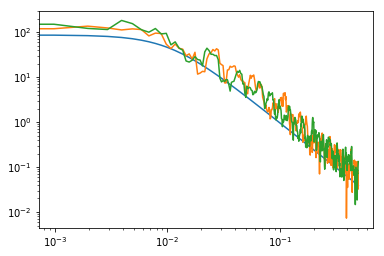

In [89]:
N, L = 1024, 2048*1e-09
freq = np.zeros(1024)
for i in range(N):
    freq[i] = i - (N/2)
freq = 2*np.pi*freq/L

num = (np.sqrt(np.pi))*(math.gamma(alpha + 0.5)/math.gamma(alpha))*(2*(Xi*1e-09)*(sigma*1e-0)**2)
denom = (1 +(freq*Xi*1e-09)**2)**(alpha + 0.5)

print(freq)
PSD = num/denom
plt.plot(freq[512:]*1e-09/(np.pi),PSD[512:]/(1e-09))
plt.yscale('log')
plt.xscale('log')
plt.plot(x_axis,right_Sk[512:])
plt.plot(x_axis,left_Sk[512:])
plt.show()